In [4]:
%matplotlib notebook
from __future__ import division
from matplotlib.pyplot import subplots
from matplotlib.patches import Ellipse
from theano_models.visualization import d3viz
from IPython.display import IFrame

In [13]:
import theano
import theano_models as tm
import theano_models.probabilistic_models as pm
import theano_models.deterministic_models as dm
import numpy as np
import time
from climin.util import optimizer
from schlichtanders.myfunctools import compose, meanmap
from schlichtanders.mygenerators import chunk as ichunk
from itertools import izip, imap, repeat as irepeat, count as icount, cycle as icycle, islice

# Model

In [14]:
base = tm.fix_params(pm.Gauss(2))
base

Gauss3_fixed { 'inputs': [], 'outputs': Gauss3.outputs}

In [15]:
locscale = dm.LocScaleTransform()
locscale

LocScaleTransform2 { 'inputs': [LocScaleTransform2.inputs.0],
  'norm_det': LocScaleTransform2.norm_det,
  'outputs': LocScaleTransform2.outputs,
  'parameters': [LocScaleTransform2.loc2],
  'parameters_positive': [LocScaleTransform2.scale2]}

In [16]:
model = tm.normalizing_flow(locscale, base)
model

normalized_flow2 { 'inputs': [],
  'norm_det': LocScaleTransform2.norm_det,
  'outputs': LocScaleTransform2.outputs,
  'parameters': [LocScaleTransform2.loc2],
  'parameters_positive': [LocScaleTransform2.scale2]}

In [17]:
parameters = tm.prox_reparameterize(model['parameters_positive'], tm.softplus, tm.softplus_inv)
parameters += model['parameters']
flat = tm.prox_flatten(tm.prox_center(parameters))

# Target

In [18]:
target = pm.Gauss(init_mean=[3,1], init_var=4)
t_sampler = target.function()
targets = np.array([t_sampler() for _ in range(10000)])
targets[:10]

array([[ 1.95343404, -0.30609492],
       [ 4.56738839,  0.54525063],
       [ 3.57420018, -0.32601176],
       [ 2.17962083,  1.02039949],
       [ 3.91151964,  1.77347345],
       [ 4.94831433,  3.24639838],
       [ 5.06933011,  0.59397061],
       [ 6.63348753,  2.25151127],
       [ 1.00678356,  0.06449716],
       [ 0.2857221 ,  0.30512598]])

# Visualized Fit

In [22]:
target_mean = target.mean.eval()
target_var = target.var.eval()
target_var = [target_var, target_var]
    
model_meanvar = theano.function([flat], [model.loc, model.scale**2])
def plot_fit(ax, wrt, time_delay=0.1):
    ax.clear()
    ax.set_xlabel("x0")
    ax.set_ylabel("x1")
    
    # plot target
    # -----------
    # Data
    ax.plot(targets[:500,0], targets[:500,1], 'k.')
    # Ellipse
    e = Ellipse(target_mean, width=2*np.sqrt(target_var[0]), height=2*np.sqrt(target_var[1]))
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.1)
    e.set_facecolor([1, 0.1, 0.1])
    ax.add_patch(e)

    # plot model
    # -----------
    model_mean, model_var = model_meanvar(wrt)
    model_var = [model_var, model_var]
    # text
    ax.text(0.1, 0.2, 'm=%g,%g' % tuple(model_mean),
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes)
    ax.text(0.1, 0.1, 'v=%g,%g' % tuple(model_var),
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes)
    # Ellipse
    e = Ellipse(model_mean, width=2*np.sqrt(model_var[0]), height=2*np.sqrt(model_var[1]))
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.2)
    e.set_facecolor([0.1, 0.2, 0.4])
    ax.add_patch(e)
    # Point  # we need to add a normal plot, as then the axis adjust automatically
    ax.plot(model_mean[0], model_mean[1], '+', color=[0.1, 0.2, 0.4], markersize=10)
    
    # interactively redraw
    # --------------------
    ax.figure.canvas.draw()
    if time_delay is not None:
        time.sleep(time_delay) # just because the fit is to fast otherwise

<IPython.core.display.Javascript object>


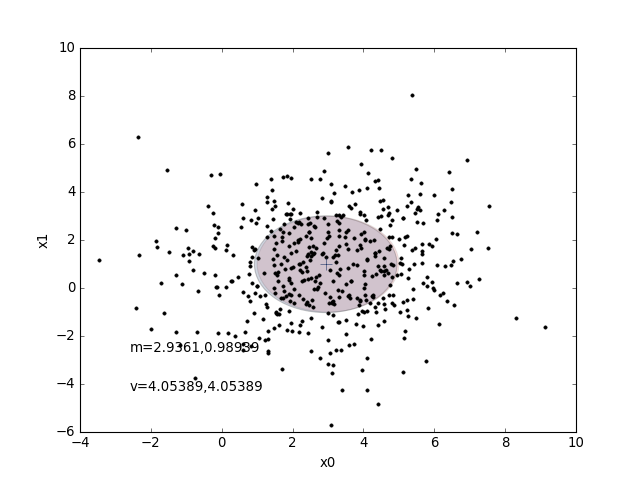

In [23]:
fig, ax = subplots()
plot_fit(ax, flat.eval())

In [25]:
batch_size = 100
loss = tm.loss_probabilistic(model)
optimizer_kwargs = tm.numericalize(loss, flat, batch_mapreduce=meanmap)
climin_args = izip(imap(lambda x:(x,), ichunk(batch_size, icycle(targets))), irepeat({}))
opt = optimizer(
    identifier="adadelta",
    args=climin_args,
    **tm.climin_kwargs(optimizer_kwargs)
)

batch_precompile
batch_precompile


/home/stephan/GitProjects/climin/climin/util.py:151: UserWarning: Argument named f is not expected by <class 'climin.adadelta.Adadelta'>
  % (i, klass))


In [26]:
for info in islice(opt, 200):
    plot_fit(ax, opt.wrt, time_delay=None)